In [8]:
import numpy as np
import pickle
import torch
import math
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from mutect3 import data, validation, plotting, spectrum, threshold, tensors

# we need to explicitly import in order for unpickling to work
from mutect3.tensors import Datum, SiteInfo, MutectInfo 
from mutect3.networks import ReadSetClassifier, ReadSetClassifierWithTemperature, PriorAdjustedReadSetClassifier

%matplotlib inline

In [9]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
REF_DOWNSAMPLE = 10 # choose this many ref reads randomly
MIN_REF = 5

TLOD_THRESHOLD = 6 # we are classified artifacts other than sequencing errors described by base qualities
NON_ARTIFACT_PER_ARTIFACT = 50 #ratio of non-artifact to artifact in unsupervised training data

BATCH_SIZE = 64

In [ ]:
"""
table_dir = '/Users/davidben/broad/mutect3/tables/'
pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
    print("Generating tensors for " + dream)
    
    tumor_table = table_dir + dream + '-tumor.table'
    normal_table = table_dir + dream + '-normal.table'
    
    # we form a few kinds of training data: tumor data using the normal 
    # (the normal doesn't change the format but helps make better truth guesses)
    print("Generating and pickling tumor tensors for training using tumor and normal")
    pair_train_pickle = pickle_dir + dream + '-pair-train.pickle'
    pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
    with open(pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data, f)
    
    #print("Generating and pickling tumor tensors for training using only tumor")
    #tumor_train_pickle = dir + dream + '-tumor-train.pickle'
    #tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
    #with open(tumor_train_pickle, 'wb') as f:
    #    pickle.dump(tumor_train_data, f)
    
    print("Generating and pickling normal tensors for training using only normal")
    normal_train_pickle = pickle_dir + dream + '-normal-train.pickle'
    normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
    with open(normal_train_pickle, 'wb') as f:
        pickle.dump(normal_train_data, f)
    
    print("Generating and pickling tumor tensors for testing using STATUS labels")
    test_pickle = pickle_dir + dream + '-test.pickle'
    test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
    with open(test_pickle, 'wb') as f:
        pickle.dump(test_data, f)
"""

In [10]:
def make_data_loaders(train, valid, test):
    train_labels = [datum.artifact_label() for datum in train]
    valid_labels = [datum.artifact_label() for datum in valid]
    class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
    class_weights = 1.0/class_counts
    
    #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact
    samples_per_epoch = 20*int(class_counts[1]) 
    
    train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    valid_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[valid_labels], num_samples = 2*len(valid_labels))

    train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, sampler=valid_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=data.collate_read_sets, drop_last=True)
    return train_loader, valid_loader, test_loader

In [11]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # track loss and accuracy as map from alt count bins to lists by epoch
    train_losses = []
    valid_losses = []
    
    valid_Fs = []
    test_Fs = []
    
    for epoch in range(1, num_epochs + 1):
        print("Epoch " + str(epoch))
        for (loader, losses, epoch_type) in [(train_loader, train_losses, "training"), (valid_loader, valid_losses, "validating")]:   
            is_training = epoch_type == "training"
            model.train(is_training)
            epoch_loss = 0

            for batch_number, batch in enumerate(loader):
                predictions = model(batch)              
                loss = criterion(predictions, batch.labels())
                epoch_loss += loss.item()

                if is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            losses.append(epoch_loss / (len(loader)*BATCH_SIZE))
        # end of epoch
        valid_Fs.append(validation.get_optimal_f_score(model, valid_loader))
        
        # generate the full posterior model after each epoch to measure test set performance
        calibrated_model = ReadSetClassifierWithTemperature(model)
        calibrated_model.set_temperature(valid_loader)
        artifact_proportion, artifact_spectrum, variant_spectrum = spectrum.learn_af_spectra(calibrated_model, test_loader, m2_filters_to_keep = {'normal_artifact'}, threshold=-4.0)
        posterior_model = PriorAdjustedReadSetClassifier(calibrated_model, artifact_proportion, artifact_spectrum, variant_spectrum)
        test_Fs.append(validation.get_optimal_f_score(posterior_model, test_loader, m2_filters_to_keep = {'normal_artifact'}))
    
    # model is trained
    
    return train_losses, valid_losses, valid_Fs, test_Fs

In [12]:
EPOCHS = 50

def run_evaluation(training_pickles, test_pickle, num_epochs=EPOCHS):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect2_data().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    train_false_variants = len([_ for datum in train if (len(datum.mutect2_data().filters()) > 1 or "germline" not in datum.mutect2_data().filters()) and datum.artifact_label() == 0])
    print("Training data includes " + str(train_false_variants) + " artifacts labelled as good variants.")
    
    # Learn model
    train_loader, valid_loader, test_loader = make_data_loaders(train, valid, test)
    model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10]).float()
    train_losses, valid_losses, valid_Fs, test_Fs = train_model(model, train_loader, valid_loader, test_loader, num_epochs)
    plotting.plot_learning_metrics([train_losses, valid_losses], ["training", "validation"], "loss") 
    plotting.plot_learning_metrics([valid_Fs, test_Fs], ["validation", "test"], "Maximal F score")
    
    calibrated_model = ReadSetClassifierWithTemperature(model)
    calibrated_model.set_temperature(valid_loader)
    
    valid_stats = validation.get_validation_stats(calibrated_model, valid_loader)[0]     
    valid_stats.plot_sensitivities("model on unsupervised validation set")
    
    # Posterior probability model
    artifact_proportion, artifact_spectrum, variant_spectrum = spectrum.learn_af_spectra(calibrated_model, test_loader, m2_filters_to_keep = {'normal_artifact'}, threshold=-4.0)
    posterior_model = PriorAdjustedReadSetClassifier(calibrated_model, artifact_proportion, artifact_spectrum, variant_spectrum)
    artifact_spectrum.plot_spectrum()
    variant_spectrum.plot_spectrum()
    
    artifact_threshold = 1 - threshold.calculate_true_prob_threshold(calibrated_model, test_loader, {'normal_artifact'})
    logit_threshold = np.log(artifact_threshold/(1 - artifact_threshold))
    
    test_stats = validation.get_validation_stats(calibrated_model, test_loader, {'normal_artifact'}, [logit_threshold])[0]
    test_stats.plot_sensitivities("model on test set")
    posterior_test_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, [-1])[0]
    posterior_test_stats.plot_sensitivities("model on test set with AF priors")
    m2_stats = validation.get_m2_validation_stats(test_loader)
    m2_stats.plot_sensitivities("Mutect2 on test set")
    print("M3 sensitivity and precision: " + str(posterior_test_stats.sensitivity()) + ", " + str(posterior_test_stats.precision()))
    print("M2 sensitivity and precision: " + str(m2_stats.sensitivity()) + ", " + str(m2_stats.precision()))
    
    roc_thresholds = [-8 + 0.25*n for n in range(64)]
    roc_curve_posterior_test_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, roc_thresholds)
    sens = [stats.sensitivity() for stats in roc_curve_posterior_test_stats]
    prec = [stats.precision() for stats in roc_curve_posterior_test_stats]
    
    # minimum distance to sens = 1, prec = 1 corner\n",
    distance_to_corner = min(math.sqrt((1-x)**2 + (1-y)**2) for x,y in zip(sens, prec))
    print("Minimum distance to sens=1, prec=1 corner: " + str(distance_to_corner))

    roc_fig = plt.figure()
    roc_curve = roc_fig.gca()
    roc_curve.plot(sens, prec, label = "ROC curve")
    roc_curve.set_xlabel("sensitivity")
    roc_curve.set_ylabel("precision")
    roc_curve.scatter([m2_stats.sensitivity()], [m2_stats.precision()])
    roc_curve.annotate("Mutect2", (m2_stats.sensitivity(), m2_stats.precision()))
    
    print([(thres,stat.sensitivity(),stat.precision()) for thres, stat in zip(roc_thresholds,roc_curve_posterior_test_stats)])
    

In [13]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 14 PASS variants labelled as artifacts.
Training data includes 168847 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
M3 sensitivity and precision: 0.9969173859432799, 0.7636363636363637
M2 sensitivity and precision: 0.9133785450061652, 0.966721044045677
Minimum distance to sens=1, prec=1 corner: 0.03966158820737863
[(-8.0, 0.9898273736128237, 0.961665169212339), (-7.75, 0.9904438964241677, 0.9579606440071556), (-7.5, 0.9910604192355117, 0.9

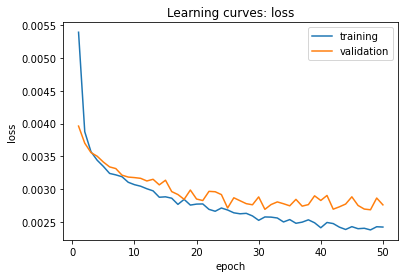

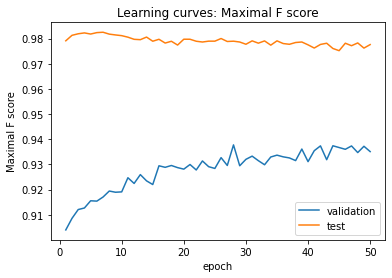

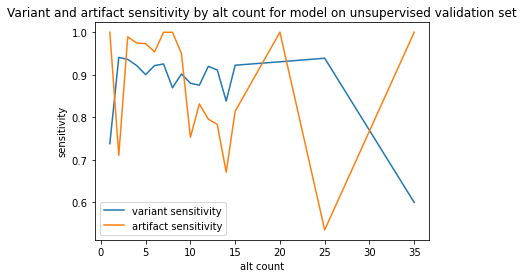

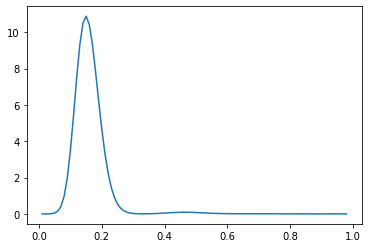

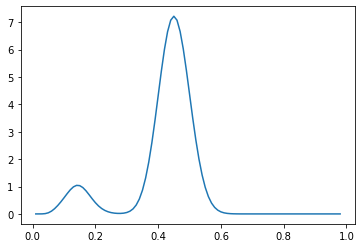

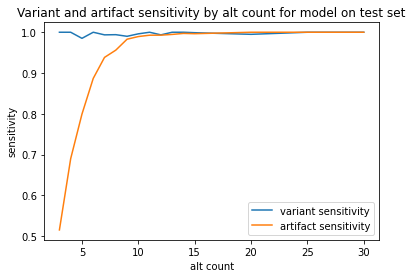

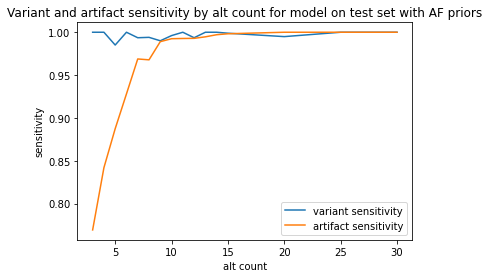

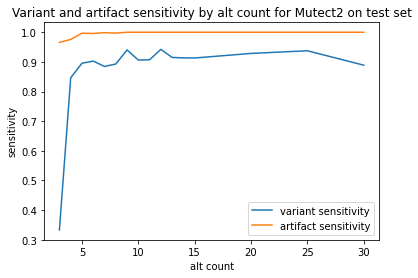

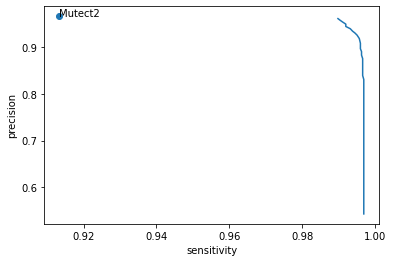

In [14]:
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)